# Gesture Recognition with CAPG DB-a Dataset (one subject for testing)

In this preliminary effort, we will try to perform hand gesture recognition from CAPG DBA dataset.

In this version:

- EMG data is normalized with the recorded MVC data
- EMG data (already preprocessed) **will not be processed** further.
- There is **no feature engineering**; raw EMG data will be used.
- The **2D ConvNet** architecture proposed by the CapgMyo paper will be exactly replicated.
- **Training data:** 17 subjects
- **Test data:** 1 subject
- K-fold cross-validation will be performed.

**NOTE** This code has been tested with:
```
    numpy version:        1.23.5
    scipy version:        1.9.3
    sklearn version:      1.2.0
    seaborn version:      0.12.1
    pandas version:       1.5.2
    torch version:        1.12.1+cu113
    matplotlib version:   3.6.2
    CUDA version:         11.2
    cuDNN version:        8.1.0
```

## 1- Preliminaries

### Imports

In [1]:
import sys, os
direc = os.getcwd()
print("Current Working Directory is: ", direc)
KUACC = False
if "scratch" in direc: # We are using the cluster
    KUACC = True
    homedir = os.path.expanduser("~")
    os.chdir(os.path.join(homedir,"REPO/comp541-project/capg_replica/"))
    direc = os.getcwd()
    print("Current Working Directory is now: ", direc)
sys.path.append("../src/")
sys.path.append("../data/")
import torch
import torch.nn as nn
from datasets_torch import *
from models_torch import *
from utils_torch import *
from datetime import datetime
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
import statistics
import json
from IPython.display import display

# Print versions
print("numpy version:       ", np.__version__)
print("scipy version:       ", sp.__version__)
print("sklearn version:     ", sklearn.__version__)
print("seaborn version:     ", sns.__version__)
print("pandas version:      ", pd.__version__)
print("torch version:       ", torch.__version__)
print("matplotlib version:  ", matplotlib.__version__)


# Checking to see if CUDA is available for us
print("Checking to see if PyTorch recognizes GPU...")
print(torch.cuda.is_available())

# Whether to use latex rendering in plots throughout the notebook
USE_TEX = False
FONT_SIZE = 12

# Setting matplotlib plotting variables
if USE_TEX:
    plt.rcParams.update({
        "text.usetex": True,
        "font.size": FONT_SIZE,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })
else:
    plt.rcParams.update({
        "text.usetex": False,
        "font.size": FONT_SIZE,
        "font.family": "serif",
        "font.serif": ["Times"]
    })

# Do not plot figures inline (only useful for cluster)
# %matplotlib

Current Working Directory is:  /scratch/users/pniaz20/REPO/comp541-project/capg_replica
Current Working Directory is now:  /scratch/users/pniaz20/REPO/comp541-project/capg_replica
numpy version:        1.22.0
scipy version:        1.4.1
sklearn version:      1.0.2
seaborn version:      0.11.2
pandas version:       1.5.2
torch version:        1.12.1+cu113
matplotlib version:   3.5.1
Checking to see if PyTorch recognizes GPU...
True


## 2- Hyperparameters and Settings

### General settings of the study

In [2]:
k_fold_study = {
    'code':'capg_replica/capg_dba_v003',
    'package':'torch',
    'dataset':'capg',
    'subdataset':'dba',
    "training_accuracies": [],
    "validation_accuracies": [],
    "testset_accuracies": [],
    "history_training_loss": [],
    "history_training_metrics": [],
    "history_validation_loss": [],
    "history_validation_metrics": [],
    "preprocessing":"mvc",
    "feature_engineering":None,
    "k_fold_mode":"1 subject for testing"
}

In [3]:
hparams = {
    "model_name": autoname("capg_replica_dba_v003"),
    # General hyperparameters
    "in_features": 128,
    "out_features": 1,
    # Sequence hyperparameters
    "in_seq_len_sec": 0,
    "out_seq_len_sec": 0,
    "data_sampling_rate_Hz": 1000.0,
    "data_downsampling": 5,
    "sequence_downsampling": 1,
    "in_seq_len": 0,
    "out_seq_len": 0,
    "validation_data": [0.05,'testset'],
    # Training hyperparameters
    "l2_reg": 0.0001,
    "batch_size": 1024,
    "epochs": 200,
    "validation_tolerance_epochs": 10,
    "learning_rate": 0.1,
    "learning_rate_decay_gamma": 0.95,
    "loss_function": "crossentropy",
    "optimizer": "adam",
    "optimizer_params": None
}

## 3- Data Processing

### Load and concatenate data

In [4]:
data_dir = "../data/CAPG/parquet"
def load_single_capg_dataset(data_dir, db_str:str="dba"):
    data_lst = []
    for i,file in enumerate(os.listdir(data_dir)):
        if file.endswith(".parquet") and db_str in file:
            print("Loading file: ", file)
            data_lst.append(pd.read_parquet(os.path.join(data_dir, file)))
    data = pd.concat(data_lst, axis=0, ignore_index=True)
    return data
dba_tot = load_single_capg_dataset(data_dir, db_str="dba")
dba_mvc = dba_tot.loc[dba_tot["gesture"].isin([100, 101])]
dba = dba_tot.loc[~dba_tot["gesture"].isin([100, 101])]
print("dba_tot shape: ", dba_tot.shape)
print("dba_mvc shape: ", dba_mvc.shape)
print("dba shape: ", dba.shape)
print("columns: ")
print(dba_tot.columns)

Loading file:  dba_subj_8.parquet
Loading file:  dba_subj_10.parquet
Loading file:  dba_subj_2.parquet
Loading file:  dba_subj_5.parquet
Loading file:  dba_subj_14.parquet
Loading file:  dba_subj_12.parquet
Loading file:  dba_subj_4.parquet
Loading file:  dba_subj_11.parquet
Loading file:  dba_subj_17.parquet
Loading file:  dba_subj_16.parquet
Loading file:  dba_subj_18.parquet
Loading file:  dba_subj_6.parquet
Loading file:  dba_subj_15.parquet
Loading file:  dba_subj_3.parquet
Loading file:  dba_subj_9.parquet
Loading file:  dba_subj_13.parquet
Loading file:  dba_subj_1.parquet
Loading file:  dba_subj_7.parquet
dba_tot shape:  (1476000, 131)
dba_mvc shape:  (36000, 131)
dba shape:  (1440000, 131)
columns: 
Index(['subject', 'gesture', 'trial', 'b_1_c_1', 'b_1_c_2', 'b_1_c_3',
       'b_1_c_4', 'b_1_c_5', 'b_1_c_6', 'b_1_c_7',
       ...
       'b_8_c_7', 'b_8_c_8', 'b_8_c_9', 'b_8_c_10', 'b_8_c_11', 'b_8_c_12',
       'b_8_c_13', 'b_8_c_14', 'b_8_c_15', 'b_8_c_16'],
      dtype='obje

### Normalize EMG Data

Here the recorded MVC values will be used for normalizaing EMG data

In [5]:
max_mvc = dba_mvc.iloc[:,3:].max(axis=0)
del dba_mvc
# print("max_mvc for 5 first channels: ")
# print(max_mvc[:5])
# print("shape of max_mvc: ", max_mvc.shape)
# print("max of dba before normalization: (first five)")
# print(dba.iloc[:,3:].max(axis=0)[:5])
dba.iloc[:,3:] = dba.iloc[:,3:].div(max_mvc, axis=1)
# print("max of dba_norm after normalization: ")
# print(dba_norm.iloc[:,3:].max(axis=0)[:5])

/tmp/ipykernel_52334/1353078018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dba.iloc[:,3:] = dba.iloc[:,3:].div(max_mvc, axis=1)


## 4- k-fold study

### CapgMyo Model

In [6]:
class CapgMyoModel(nn.Module):
    def __init__(self):
        super(CapgMyoModel, self).__init__()
        layers = []
        
        layers.append(nn.BatchNorm2d(1))
        layers.append(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=[3,3], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[3,3], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,1], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=[1,1], padding='same'))
        layers.append(nn.BatchNorm2d(64))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout2d(0.5))
        
        layers.append(nn.Flatten())
        
        layers.append(nn.Linear(64*8*16, 512))
        layers.append(nn.BatchNorm1d(512))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        layers.append(nn.Linear(512, 512))
        layers.append(nn.BatchNorm1d(512))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(0.5))
        
        layers.append(nn.Linear(512, 128))
        layers.append(nn.BatchNorm1d(128))
        layers.append(nn.ReLU())
        
        layers.append(nn.Linear(128, 8))
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
        
model = CapgMyoModel()
print(model)        

CapgMyoModel(
  (net): Sequential(
    (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Dropout2d(p=0.5, inplace=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=8192, out_features=512, bias=True)
    (16): Batc

### Perform k-fold cross-validation study

In [7]:
# Define input columns
input_cols = list(dba.iloc[:,3:].columns)

# Hard-code total number of trials
NUM_SUBJECTS = 18

for k in range(NUM_SUBJECTS):
    
    print("\n#################################################################")
    print("Using subject %d for testing ..." % (k+1))
    print("#################################################################\n")
    
    subj_for_testing = [k+1]
    
    # Un-Correct the output feature count (this is buggy behavior and should be fixed)
    hparams['out_features'] = 1
    
    # Get processed data cell
    data_processed = generate_cell_array(
        dba, hparams,
        subjects_column="subject", conditions_column="gesture", trials_column="trial",
        input_cols=input_cols, output_cols=["gesture"], specific_conditions=None,
        input_preprocessor=None,
        output_preprocessor=None,
        input_postprocessor=lambda arr: arr.reshape(-1,1,8,16),
        subjects_for_testing=subj_for_testing,
        input_scaling=False, output_scaling=False, input_forward_facing=True, output_forward_facing=True, 
        data_squeezed=False,
        input_towards_future=False, output_towards_future=False, 
        output_include_current_timestep=True,
        use_filtered_data=False, #lpcutoff=CUTOFF, lporder=FILT_ORDER, lpsamplfreq=SAMPL_FREQ,
        return_data_arrays_orig=False,
        return_data_arrays_processed=False,
        return_train_val_test_arrays=False,
        return_train_val_test_data=True,
        verbosity=1
    )
    
    # Correct the output feature count (this is buggy behavior and should be fixed)
    hparams['out_features'] = 8
    
    # Inputs MUST have the correct shape
    x_train = data_processed["x_train"]
    x_val = data_processed["x_val"]
    x_test = data_processed["x_test"]
    # Outputs MUST be zero-indexed class labels
    y_train = data_processed["y_train"] - 1
    y_val = data_processed["y_val"] - 1
    y_test = data_processed["y_test"] - 1
    print("x_train shape: ", x_train.shape)
    print("x_val shape: ", x_val.shape)
    print("x_test shape: ", x_test.shape)
    print("y_train shape: ", y_train.shape)
    print("y_val shape: ", y_val.shape)
    print("y_test shape: ", y_test.shape)
    # Targets need to be squeezed for the loss function. It wants (N,) or (N,C) where C > 1, not (N,1).
    y_train = y_train.squeeze()
    y_val = y_val.squeeze()
    y_test = y_test.squeeze()
    # Make datasets from training, validation and test sets
    train_set = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).long())
    val_set = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val).long())
    test_set = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).long())
    
    # If it is the first iteration of the loop, save the hyperparameters dictionary in the k-fold study dictionary
    if k==0:
        k_fold_study['hparams'] = hparams
    
    # Construct model
    model = CapgMyoModel()
    
    
    # Train model
    history = train_pytorch_model(
            model, [train_set, val_set], batch_size=1024, loss_str='crossentropy', optimizer_str='adam', 
            optimizer_params={'weight_decay':0.0001}, loss_function_params=None, learnrate=0.1, 
            learnrate_decay_gamma=0.95, epochs=200, validation_patience=10000, 
            verbose=1, script_before_save=True, saveto=None, num_workers=0)    
        
    # Update relevant fields in the k-fold study dictionary
    k_fold_study['history_training_loss'].append(history["training_loss"])
    k_fold_study["history_validation_loss"].append(history["validation_loss"])
    k_fold_study["history_training_metrics"].append(history["training_metrics"])
    k_fold_study["history_validation_metrics"].append(history["validation_metrics"])
    k_fold_study["training_accuracies"].append(history["training_metrics"][-1])
    k_fold_study["validation_accuracies"].append(history["validation_metrics"][-1])
    
    # Evaluate the model on the test set
    results = evaluate_pytorch_model(model, test_set, loss_str='crossentropy', loss_function_params=None,
        batch_size=1024, device_str="cuda", verbose=True, num_workers=0)
    
    k_fold_study["testset_accuracies"].append(results["metrics"])


#################################################################
Using subject 1 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [1]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671678
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1, 8, 16)
y_train shape:  (272000, 1)
y_val shape:  (800, 1)
y_test shape:  (15200, 1)
Total number of data points:      272800
Number of training data points:   272000
Number of validation data points: 800
Number 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [31:08<00:00,  9.34s/it]


Finished Training.
Training process took 1868.80 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.7212 | Accuracy: 0.1990
Done.

#################################################################
Using subject 2 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [2]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:32<00:00,  9.16s/it]


Finished Training.
Training process took 1832.05 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 1.6904 | Accuracy: 0.3810
Done.

#################################################################
Using subject 3 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [3]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:38<00:00,  9.19s/it]


Finished Training.
Training process took 1838.93 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 1.8230 | Accuracy: 0.3184
Done.

#################################################################
Using subject 4 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [4]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:34<00:00,  9.17s/it]


Finished Training.
Training process took 1834.63 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.1078 | Accuracy: 0.3200
Done.

#################################################################
Using subject 5 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [5]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671678
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:33<00:00,  9.17s/it]


Finished Training.
Training process took 1833.90 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 1.8984 | Accuracy: 0.3254
Done.

#################################################################
Using subject 6 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [6]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:32<00:00,  9.16s/it]


Finished Training.
Training process took 1832.69 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.4698 | Accuracy: 0.2031
Done.

#################################################################
Using subject 7 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [7]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:31<00:00,  9.16s/it]


Finished Training.
Training process took 1831.16 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.7066 | Accuracy: 0.2166
Done.

#################################################################
Using subject 8 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [8]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671678
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:31<00:00,  9.16s/it]


Finished Training.
Training process took 1831.60 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.4183 | Accuracy: 0.2666
Done.

#################################################################
Using subject 9 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [9]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 1,

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:31<00:00,  9.16s/it]


Finished Training.
Training process took 1831.72 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.1631 | Accuracy: 0.2210
Done.

#################################################################
Using subject 10 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [10]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671678
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:29<00:00,  9.15s/it]


Finished Training.
Training process took 1829.52 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.9804 | Accuracy: 0.1347
Done.

#################################################################
Using subject 11 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [11]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:23<00:00,  9.12s/it]


Finished Training.
Training process took 1823.48 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 4.8695 | Accuracy: 0.0612
Done.

#################################################################
Using subject 12 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [12]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:24<00:00,  9.12s/it]


Finished Training.
Training process took 1824.28 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.7444 | Accuracy: 0.1888
Done.

#################################################################
Using subject 13 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [13]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:23<00:00,  9.12s/it]


Finished Training.
Training process took 1823.92 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 1.9688 | Accuracy: 0.2946
Done.

#################################################################
Using subject 14 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [14]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:25<00:00,  9.13s/it]


Finished Training.
Training process took 1825.67 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 4.0752 | Accuracy: 0.1283
Done.

#################################################################
Using subject 15 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [15]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:23<00:00,  9.12s/it]


Finished Training.
Training process took 1823.07 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.0573 | Accuracy: 0.3068
Done.

#################################################################
Using subject 16 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [16]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:26<00:00,  9.13s/it]


Finished Training.
Training process took 1826.15 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.0822 | Accuracy: 0.2949
Done.

#################################################################
Using subject 17 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [17]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671706
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:25<00:00,  9.13s/it]


Finished Training.
Training process took 1825.74 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.4975 | Accuracy: 0.2116
Done.

#################################################################
Using subject 18 for testing ...
#################################################################

# subjects:    18
# conditions:  8
# trials:      10


subjects used for testing:    [18]
conditions used for testing:  []
trials used for testing:      []


Iterating through all trials ...

Concatenating arrays and generating outputs ...
Validation data source:   testset
Validation data portion:  0.05
x_train:  (272000, 1, 8, 16)
y_train:  (272000, 1)
x_val:  (800, 1, 8, 16)
y_val:  (800, 1)
x_test:  (15200, 1, 8, 16)
y_test:  (15200, 1)
Constructing output dictionary ...
Size of output dictionary in bytes:  148671678
Done.

x_train shape:  (272000, 1, 8, 16)
x_val shape:  (800, 1, 8, 16)
x_test shape:  (15200, 

Training Progress: 100%|██████████████████████████████████████████| 200/200 [30:23<00:00,  9.12s/it]


Finished Training.
Training process took 1823.96 seconds.
Done training.
Preparing data...
selected device:  cuda
Evaluating model...
[█████████████████████████████████████] Loss: 2.0218 | Accuracy: 0.3064
Done.


### Saving k-fold study

In [8]:
json.dump(k_fold_study, open(make_path("../results/"+hparams['model_name']+"/k_fold_study.json"), "w"), indent=4)

### Saving general statistics

In [9]:
trn_acc_arr = np.array(k_fold_study["training_accuracies"])
val_acc_arr = np.array(k_fold_study["validation_accuracies"])
tst_acc_arr = np.array(k_fold_study["testset_accuracies"])
general_dict = {"training_accuracy":trn_acc_arr, "validation_accuracy":val_acc_arr, "testset_accuracy":tst_acc_arr}
general_results = pd.DataFrame(general_dict)
print("Description of general results:")
general_results_describe = general_results.describe()
display(general_results_describe)
general_results_describe.to_csv(
    make_path("../results/"+hparams['model_name']+"/general_results.csv"), header=True, index=True)

Description of general results:


,training_accuracy,validation_accuracy,testset_accuracy
count,18.000000,18.000000,18.000000
mean,0.737266,0.240139,0.243242
std,0.010950,0.084752,0.083316
min,0.711125,0.051250,0.061184
25%,0.731355,0.184375,0.200033
50%,0.737757,0.236250,0.243783
75%,0.746218,0.309688,0.306727
max,0.756379,0.366250,0.380987


### Plotting training histories

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


Shape of train_loss:  (18, 200)
Shape of train_loss_mean:  (200,)
Shape of train_loss_std:  (200,)


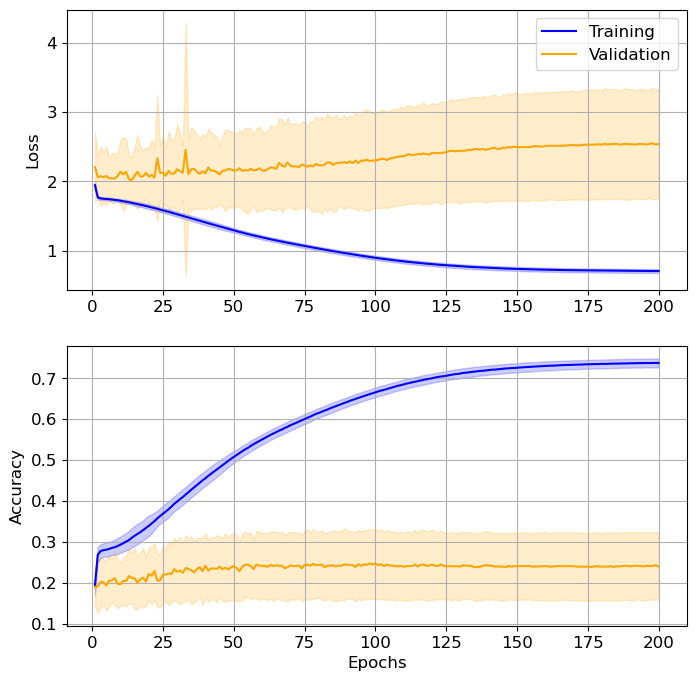

In [10]:
train_loss = np.array(k_fold_study["history_training_loss"])
val_loss = np.array(k_fold_study["history_validation_loss"])
train_acc = np.array(k_fold_study["history_training_metrics"])
val_acc = np.array(k_fold_study["history_validation_metrics"])

print("Shape of train_loss: ", train_loss.shape)

train_loss_mean = np.mean(train_loss, axis=0)
train_loss_std = np.std(train_loss, axis=0)# / 2
val_loss_mean = np.mean(val_loss, axis=0)
val_loss_std = np.std(val_loss, axis=0)# / 2
train_acc_mean = np.mean(train_acc, axis=0)
train_acc_std = np.std(train_acc, axis=0)# / 2
val_acc_mean = np.mean(val_acc, axis=0)
val_acc_std = np.std(val_acc, axis=0)# / 2

print("Shape of train_loss_mean: ", train_loss_mean.shape)
print("Shape of train_loss_std: ", train_loss_std.shape)

epochs = hparams['epochs']
epochs = np.arange(1, epochs+1)
plt.figure(figsize=(8,8), dpi=100)
plt.subplot(2,1,1)
plt.grid(True)
plt.plot(epochs, train_loss_mean, label="Training", color="blue")
plt.fill_between(epochs, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, 
                 color='blue', alpha=0.2)
plt.plot(epochs, val_loss_mean, label="Validation", color="orange")
plt.fill_between(epochs, val_loss_mean-val_loss_std, val_loss_mean+val_loss_std,
                 color='orange', alpha=0.2)
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.subplot(2,1,2)
plt.grid(True)
plt.plot(epochs, train_acc_mean, color="blue")
plt.fill_between(epochs, train_acc_mean-train_acc_std, train_acc_mean+train_acc_std,
                 color='blue', alpha=0.2)
plt.plot(epochs, val_acc_mean, color="orange")
plt.fill_between(epochs, val_acc_mean-val_acc_std, val_acc_mean+val_acc_std,
                 color='orange', alpha=0.2)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.subplots_adjust(hspace=0.2)
plt.savefig(make_path("../results/"+hparams['model_name']+"/training_history.png"), dpi=300)